In [3]:

import cv2, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

RESIZE_DIM = 512

def laplacian_variance(image, ksize=3):
    return cv2.Laplacian(image, cv2.CV_64F, ksize=ksize).var()

def fft_high_freq(image, size = 60):
    (h, w) = image.shape
    # center of the image
    (cX, cY) = (int(w / 2.0), int(h / 2.0))
    # Perform 2D Fast Fourier Transform on the image
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    # set center pixels to zero
    fshift[cY - size:cY + size, cX - size:cX + size] = 0

    # inverse fft
    f_ishift = np.fft.ifftshift(fshift)

    img_back = np.fft.ifft2(f_ishift)
    magnitude = 20*np.log(np.abs(img_back))
    mean_magnitude = np.mean(magnitude)
    return mean_magnitude

image_path = 'sample_images/blur_dataset_scaled/defocused_blurred/0_IPHONE-SE_F.JPG'
# image_path = '/Users/michael/git/blur_detection/sample_images/blur_dataset_scaled/sharp/0_IPHONE-SE_S.JPG'
image = cv2.imread(image_path)

# 一般來說，我們在處理圖片時，會先將圖片轉換成灰階圖片，這樣可以減少計算量，並且可以避免色彩對於圖片特徵的影響。
# 這裡使用 cv2.cvtColor() 函數將圖片轉換成灰階圖片。
# 因為 cv2.imread() 讀取的圖片是 BGR 格式，而不是 RGB 格式。
# Gray=0.299×Red+0.587×Green+0.114×Blue 主要是因為人眼對於綠色的敏感度最高，對於藍色的敏感度最低。

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 影像的大小會影響到 Laplacian 算子的計算結果，因此我們需要將影像的大小統一。
# 這裡使用 cv2.resize() 函數將影像的大小統一成 512x512。
resized_image = cv2.resize(gray_image, (RESIZE_DIM, RESIZE_DIM))

print("laplacian_variance:",laplacian_variance(resized_image))
print("fft_high_freq:",fft_high_freq(resized_image))


laplacian_variance: 187.33170602092287
fft_high_freq: 1.0356503223012195


In [15]:
pd.options.mode.chained_assignment = None
dataset_root = './dataset'

# use os.work to recursively list all files in the directory
def list_all_files(root):
    all_files = []
    dir2label = {"defocused_blurred": 0, "motion_blurred": 0, "sharp": 1}
    for root, dirs, files in os.walk(root):
        for file in files:
            if file.endswith('.JPG') or file.endswith('.jpg'):
                label = dir2label[root.split('/')[-1]]
                all_files.append({'image_path':os.path.join(root, file),
                                  'label':label})
    return all_files


# %%
dataset_root_dict = list_all_files(dataset_root)
# %%

pd_data = pd.DataFrame(dataset_root_dict)
# %%
pd_data.describe()
pd_data.label.value_counts()
# %%
# add new columns: laplacian_variance and fft_high_freq to store the features
pd_data['laplacian_variance'] = 0.0
pd_data['fft_high_freq'] = 0.0

# %%
for i in pd_data.image_path.index:
    img = cv2.imread(pd_data.image_path.iloc[i])
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(gray_img, (RESIZE_DIM, RESIZE_DIM))
    pd_data['laplacian_variance'].iloc[i] = laplacian_variance(resized_img)
    pd_data['fft_high_freq'].iloc[i] = fft_high_freq(resized_img)
# %%


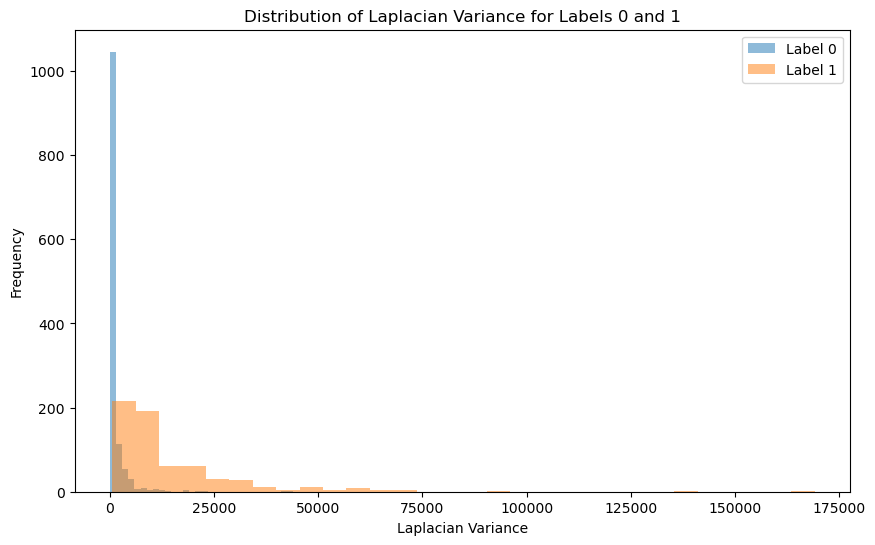

In [5]:

# 篩選出 label 為 0 的數據
label0_data = pd_data[pd_data['label'] == 0]['laplacian_variance']

# 篩選出 label 為 1 的數據
label1_data = pd_data[pd_data['label'] == 1]['laplacian_variance']

# 繪製直方圖
plt.figure(figsize=(10, 6))
plt.hist(label0_data, bins=30, alpha=0.5, label='Label 0')
plt.hist(label1_data, bins=30, alpha=0.5, label='Label 1')
plt.xlabel('Laplacian Variance')
plt.ylabel('Frequency')
plt.title('Distribution of Laplacian Variance for Labels 0 and 1')
plt.legend()
plt.show()
# %%


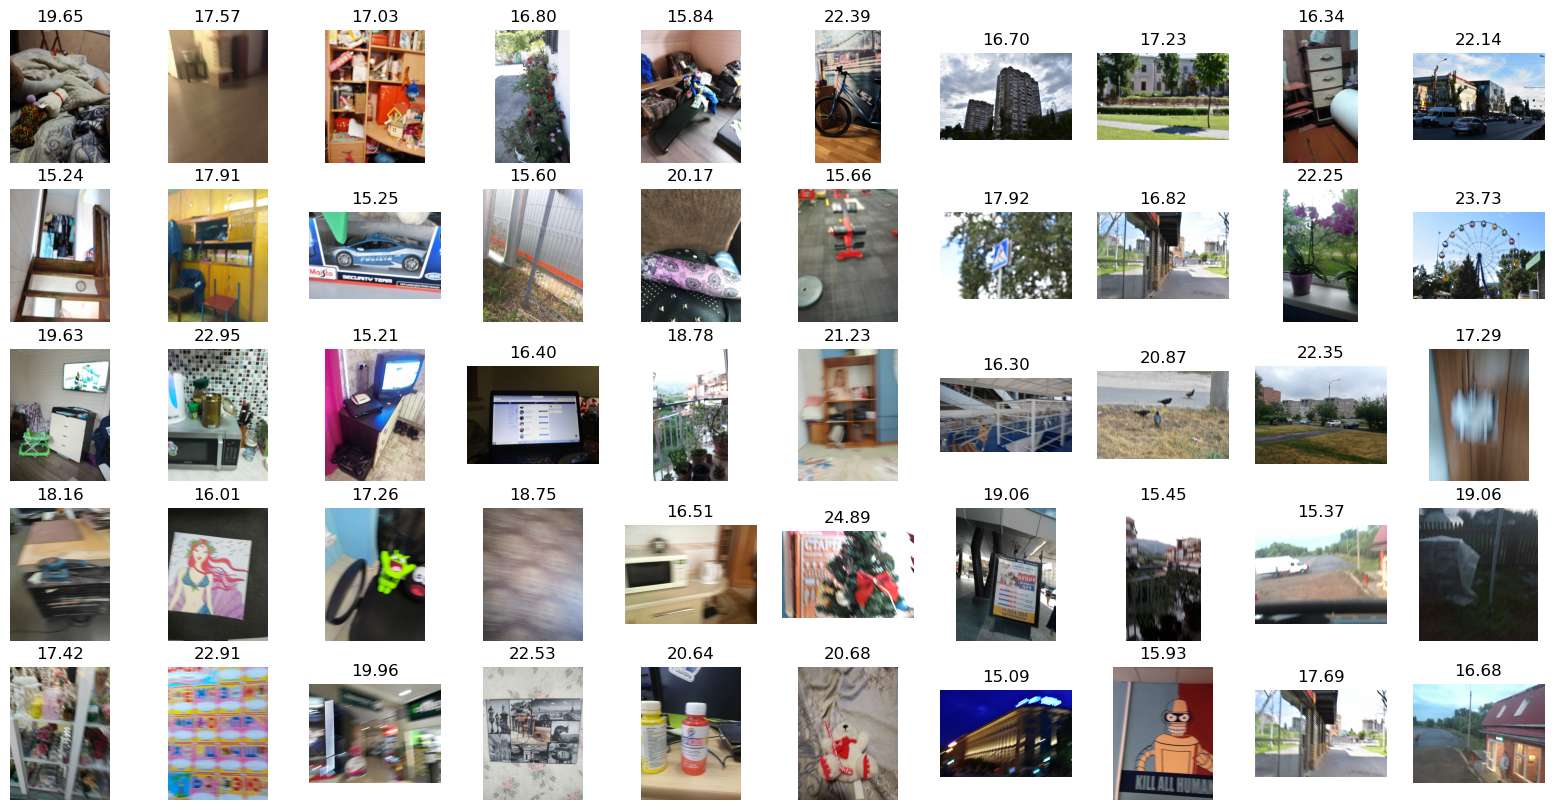

In [6]:

# 可以觀察到fft_high_freq 20左右為一個分界點，因此我們可以將其作為特徵進行分類
# 觀察15-25之間的數據
pd_data_15_25 = pd_data[(pd_data['fft_high_freq'] > 15) & (pd_data['fft_high_freq'] < 25)]
# %%
# 將選取的圖片顯示出來，顯示50張圖片，畫出10x5的子圖，並顯示圖片的fft_high_freq數值
plt.figure(figsize=(20, 10))
for i in range(50):
    plt.subplot(5, 10, i+1)
    img = cv2.imread(pd_data_15_25.image_path.iloc[i])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'{pd_data_15_25.fft_high_freq.iloc[i]:.2f}')
    plt.axis('off')
plt.show()


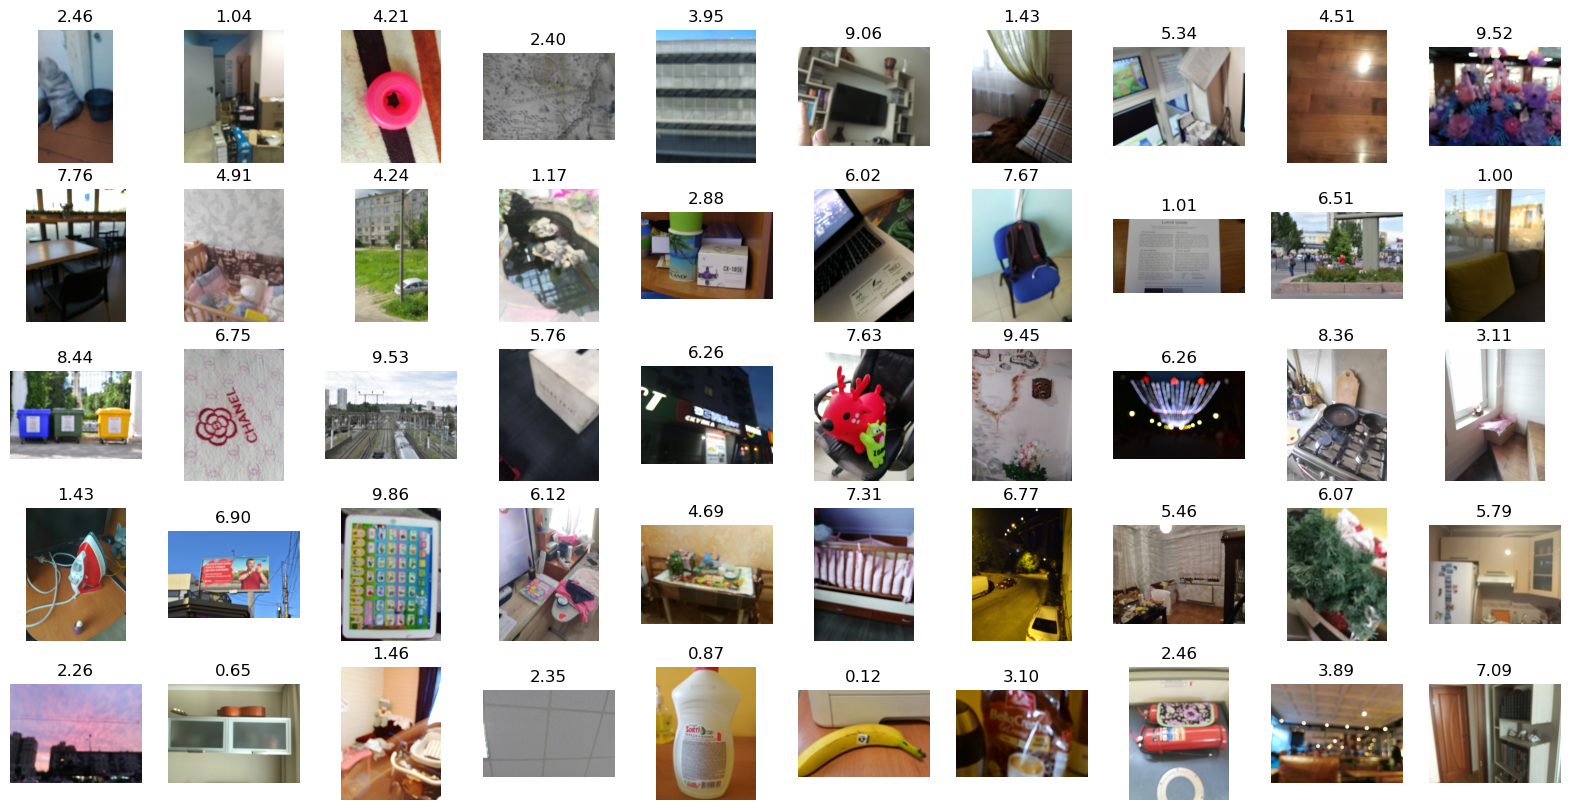

In [7]:
# %%
pd_data_0_10 = pd_data[(pd_data['fft_high_freq'] > 0) & (pd_data['fft_high_freq'] < 10)]
# %%
# 將選取的圖片顯示出來，顯示50張圖片，畫出10x5的子圖，並顯示圖片的fft_high_freq數值
plt.figure(figsize=(20, 10))
for i in range(50):
    plt.subplot(5, 10, i+1)
    img = cv2.imread(pd_data_0_10.image_path.iloc[i])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'{pd_data_0_10.fft_high_freq.iloc[i]:.2f}')
    plt.axis('off')
plt.show()
# %%


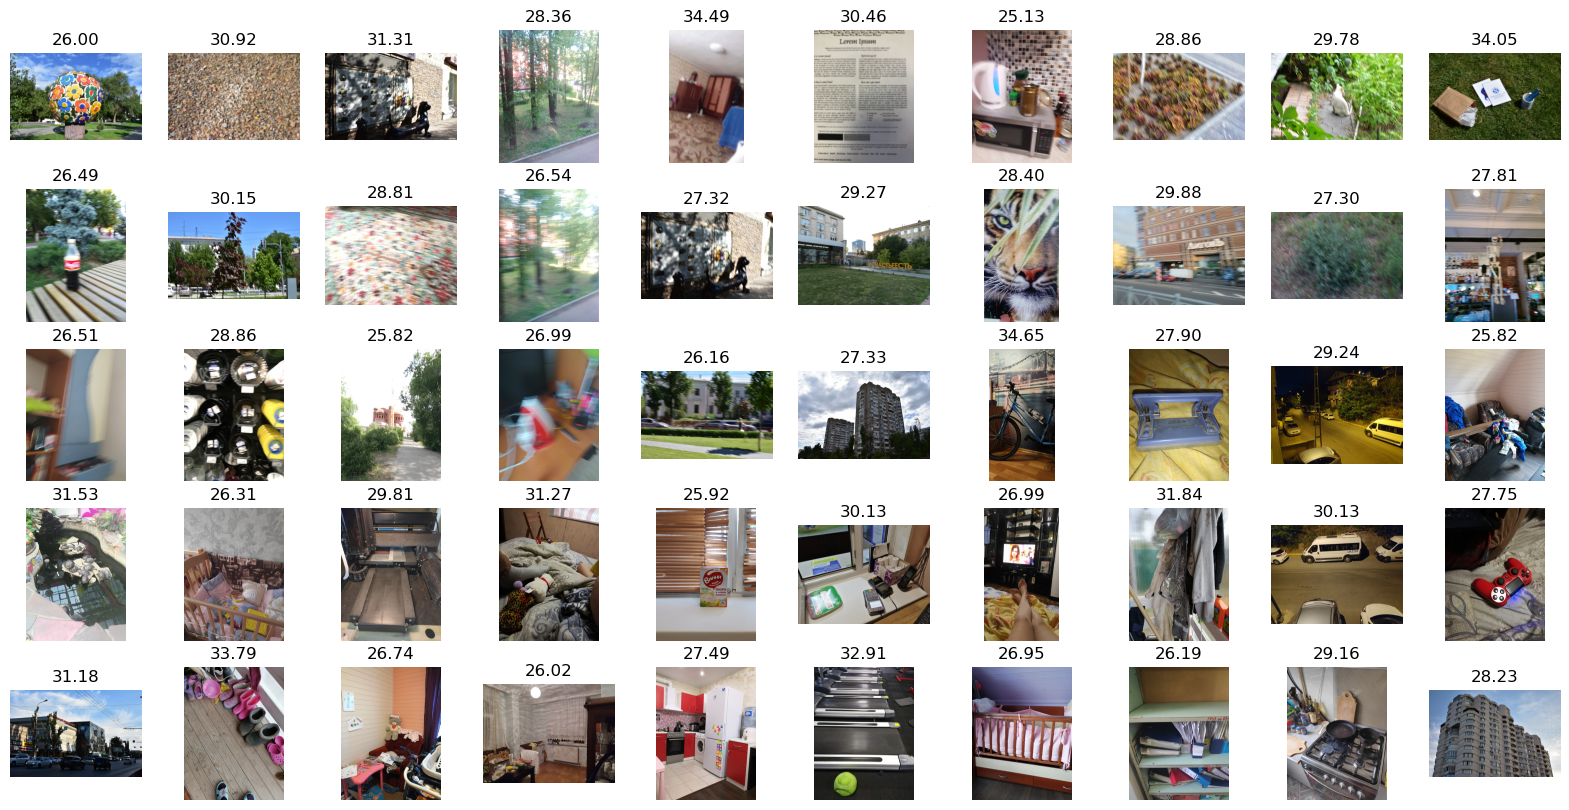

In [8]:
pd_data_25_35 = pd_data[(pd_data['fft_high_freq'] > 25) & (pd_data['fft_high_freq'] < 35)]
# %%
# 將選取的圖片顯示出來，顯示50張圖片，畫出10x5的子圖，並顯示圖片的fft_high_freq數值
plt.figure(figsize=(20, 10))
for i in range(50):
    plt.subplot(5, 10, i+1)
    img = cv2.imread(pd_data_25_35.image_path.iloc[i])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'{pd_data_25_35.fft_high_freq.iloc[i]:.2f}')
    plt.axis('off')
plt.show()


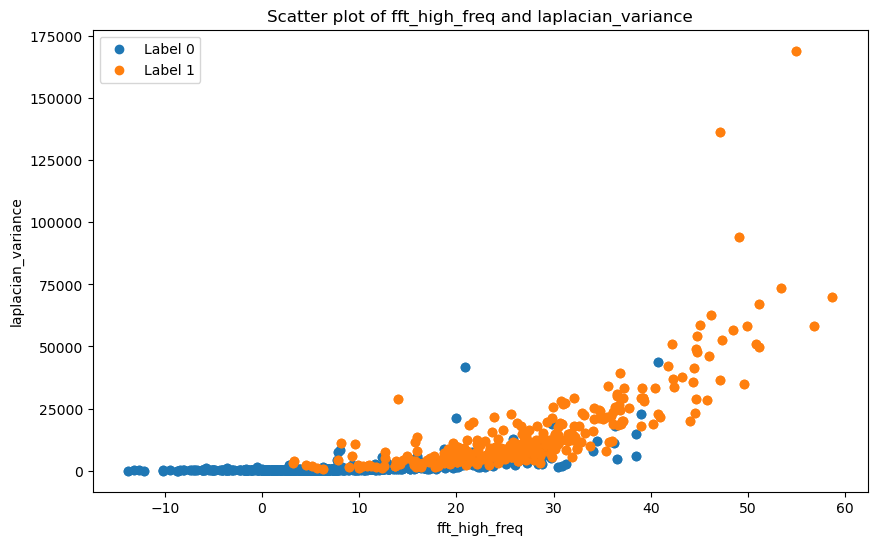

In [9]:
# %%
# 顯示fft_high_freq與laplacian_variance的散點圖
plt.figure(figsize=(10, 6))
plt.scatter(pd_data[pd_data['label'] == 0]['fft_high_freq'], pd_data[pd_data['label'] == 0]['laplacian_variance'], label='Label 0')
plt.scatter(pd_data[pd_data['label'] == 1]['fft_high_freq'], pd_data[pd_data['label'] == 1]['laplacian_variance'], label='Label 1')
plt.xlabel('fft_high_freq')
plt.ylabel('laplacian_variance')
plt.title('Scatter plot of fft_high_freq and laplacian_variance')
plt.legend()
plt.show()




In [10]:

# using sklearn package to seperate train and test set

# 在 Python 的 sklearn (Scikit-learn) 庫中，你可以使用 train_test_split 函數來將你的數據集分割成訓練集和測試集。這是機器學習預處理中常見的步驟，用於確保模型在未見過的數據上的泛化能力。

X = pd_data[['laplacian_variance', 'fft_high_freq']]
y = pd_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# %%
# 創建線性迴歸對象
model = LinearRegression()

# 訓練模型使用訓練集
model.fit(X_train, y_train)
# %%
# 在測試集上預測
y_pred = model.predict(X_test)

# 計算均方誤差和 R^2 分數
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 0.12116430729263733
R^2 Score: 0.4139055248720691


In [11]:
# %%
converted_y_pred = np.where(y_pred > 0.5, 1, 0)
# %%
# 計算準確率
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, converted_y_pred)
print(f"Accuracy: {accuracy}")

# 計算精確率
precision = precision_score(y_test, converted_y_pred, average='binary')
print(f"Precision: {precision}")

# 計算召回率
recall = recall_score(y_test, converted_y_pred, average='binary')
print(f"Recall: {recall}")

# 計算 F1 分數
f1 = f1_score(y_test, converted_y_pred, average='binary')
print(f"F1 Score: {f1}")
# %%
# Accuracy: 0.8527131782945736
# Precision: 0.7745098039215687
# Recall: 0.6991150442477876
# F1 Score: 0.7348837209302326


Accuracy: 0.8527131782945736
Precision: 0.7745098039215687
Recall: 0.6991150442477876
F1 Score: 0.7348837209302326


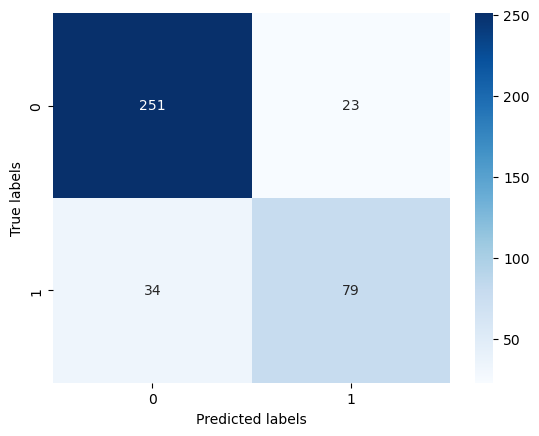

In [12]:

# 畫出混淆矩陣
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, converted_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


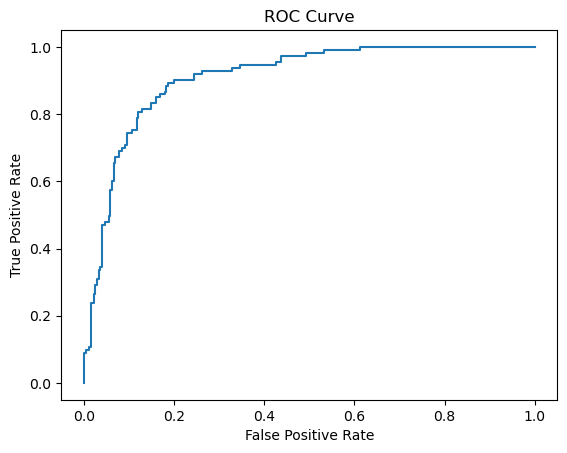

AUC: 0.9091143982946837


In [13]:

# %%
# 畫出ROC曲線
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# %%
# 計算AUC
auc = roc_auc_score(y_test, y_pred)
print(f"AUC: {auc}")


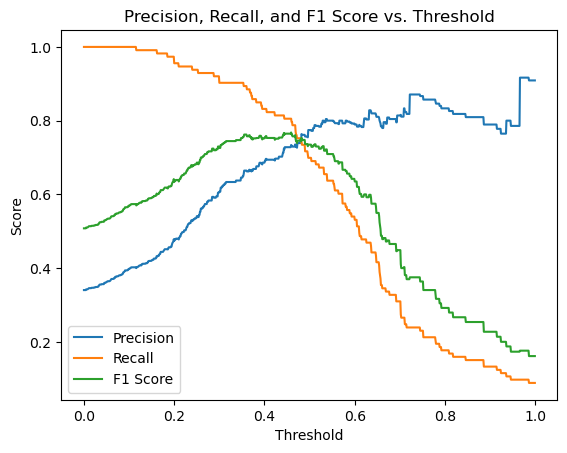

0.459


In [14]:

# %%
# 畫出不同threshold下的precision和recall與f1 score的關係
thresholds = np.arange(0, 1, 0.001)
precisions = [precision_score(y_test, np.where(y_pred > threshold, 1, 0)) for threshold in thresholds]
recalls = [recall_score(y_test, np.where(y_pred > threshold, 1, 0)) for threshold in thresholds]
f1_scores = [f1_score(y_test, np.where(y_pred > threshold, 1, 0)) for threshold in thresholds]
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()
plt.show()
# %%
# 最佳threshold
best_threshold = thresholds[np.argmax(f1_scores)]
print(best_threshold)
# %%
# 使用最佳threshold建立預測模型